In [30]:
# Import libraries

import os, sys, warnings
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import Markdown as md

#sys.path.append('../Environment/')
#from Environment.environment import *
%run ../Environment/environment.ipynb

In [31]:
def print_matrix(name, matrix):
    matrix = np.atleast_2d(matrix)
    s = ''
    for idx, v in enumerate(matrix.flatten()):
        s = s + ' {:0.3f} '.format(v)
        if idx != (matrix.size-1):
            if idx % matrix.shape[0] == matrix.shape[0]-1:
                s = s + '\\\\'
            else:
                s = s + '&'
    return md(name + ' = $' + '\\begin{bmatrix}' + s + '\\end{bmatrix}$')

# Initialize Environment / Model Variables

In [32]:
# Restart the environment
env = EnvironmentState()

# Define the actions
ACTIONS = np.asarray([0, 1, 2, 3, 4])
NUM_ACTIONS = len(ACTIONS)

# Define the state space, defined to be the possible y positions of te agent.
NUM_POS_STATES = (env.REGION_HEIGHT/0.05)+1
NUM_ANG_STATES = (160/3)+1
POS_STATES = np.linspace(0, env.REGION_HEIGHT, int(NUM_POS_STATES)) - env.REGION_HEIGHT/2
ANG_STATES = np.round(np.round(np.linspace(100, 260, int(NUM_ANG_STATES))))

NUM_ANG_STATES = 1
ANG_STATES = np.array([0])

# Run Sarsa($\lambda$) Learning Algorithm

In [33]:
# Initialize parameters
NUM_OBS = 0 # Number of obstacles
NUM_STEPS = 100 # Number of steps in an episode
NUM_EPISODES = 1000

alpha = 0.02
Lambdas = [0.25, 0.5, 0.75, 1]

eps   = 0.01
gamma = 0.90

N_TRIALS = len(alphas)

def action_from_epsilon_greedy(epsilon, Q_at_state):
    Q_at_state = np.squeeze(Q_at_state)
    # Create a policy based on epsilon greedy
    if len(np.unique(Q_at_state)) <= 1: # If all Q values are same, set policy to equal for all actions
        pi = np.zeros((NUM_ACTIONS))
        pi[:] = 1/NUM_ACTIONS
    elif len(np.unique(Q_at_state)) <= 4: # If multiple Q have a max, assign priority to the first max Q value
        pi = np.asarray([((1 - eps) + eps/NUM_ACTIONS if Q_at_state[i]==np.max(Q_at_state) else eps/NUM_ACTIONS) for i in range(NUM_ACTIONS)])
        ind = np.where(pi == np.max(pi))[0]
        pi[ind[1:]] = eps/NUM_ACTIONS
    else:
        pi = np.asarray([((1 - eps) + eps/NUM_ACTIONS if Q_at_state[i]==np.max(Q_at_state) else eps/NUM_ACTIONS) for i in range(NUM_ACTIONS)])
    return np.random.choice(ACTIONS, replace = True, p = pi)

def get_env_state(env):
    pos = np.argmin(np.abs(POS_STATES - env._agent_position_y))
    ang = np.argmin(np.abs(ANG_STATES - env._agent_aiming_angle))
    return pos, ang

trials = {Lambda:{} for Lambda in Lambdas}

for Lambda in Lambdas:
    # Q is a state x action matrix
    # Column 1 is wait action, 2 is pos up, 3 is pos down, 4 is aim up, 5 is aim down
    # Each row corresponds to a pos state
    Q = np.random.rand(int(NUM_POS_STATES), int(NUM_ANG_STATES), int(NUM_ACTIONS))
    el = np.zeros((int(NUM_POS_STATES), int(NUM_ANG_STATES), int(NUM_ACTIONS)))
    
    hits  = np.zeros((NUM_EPISODES))
    R_SUM = np.zeros((NUM_EPISODES))
    MSE   = np.zeros((NUM_EPISODES))

    # Sarsa-Lambda learning model
    for episode in range(NUM_EPISODES):
        if np.mod(episode, np.ceil(NUM_EPISODES/25)) == 0: 
            print('Running episode {} of {}...'.format(episode, NUM_EPISODES))
            
        # Try different levels of complexity for agent and target position
        env.initialize() 
        env.centered_obstruction()
        
        sp, sa = get_env_state(env)
        
        # Choose action based on epsilon-greedy policy
        a = action_from_epsilon_greedy(eps, Q[sp, 0, :])

        R_vector = np.zeros((NUM_STEPS))
        n = 0
        while True:
            # Find the current state
            sp, sa = get_env_state(env)
            
            # Decay eligibility traces
            for (sp, sa, a), v in np.ndenumerate(Q):
                el[sp, sa, a] = gamma * Lambda * el[sp, sa, a]
            
            # Increment trace of current state-action pair
            el[sp, sa, a] = el[sp, sa, a] + 1
            
            # Take action a
            env.take_action(a)
            
            # Observe reward R, new state S'
            R = env.compute_reward()
            sp_prime, sa_prime = get_env_state(env)
            
            # Collect the reward
            R_vector[n] = R
            
            # Choose a' from epsilon greedy policy derived from Q
            a_prime = action_from_epsilon_greedy(eps, Q[sp_prime, 0, :])
            
            # Compute delta
            delta = R + gamma*Q[sp_prime, 0, a_prime] - Q[sp, 0, a]
            
            # Update Q values
            for (sp, sa, a), v in np.ndenumerate(Q):
                Q[sp, sa, a] = Q[sp, sa, a] + alpha * delta * el[sp, sa, a]
                
            # Now in s', assign next action a' to greedy prediction
            a = a_prime

            n = n + 1
            # At the end of the episode, determine if the algorithm hit the target and break
            # the loop to move on to the next episode
            if n == NUM_STEPS:
                hits[episode] = 1 if R > 0 else 0 # If agent is aiming at the target, R is 1. 
                R_SUM[episode] = np.sum(R_vector)
                MSE[episode]  = np.var(R_vector) # For the unbiased case, the RSE is the variance
                break
    
    # assemble trial collection
    trials[Lambda] = dict(
        Q=Q,
        hits=hits,
        R_SUM=R_SUM,
        MSE=MSE,
    )
    
# print(hits)
print(np.sum(hits)/len(hits))

Running episode 0 of 1000...
Running episode 40 of 1000...
Running episode 80 of 1000...
Running episode 120 of 1000...
Running episode 160 of 1000...
Running episode 200 of 1000...
Running episode 240 of 1000...
Running episode 280 of 1000...
Running episode 320 of 1000...
Running episode 360 of 1000...
Running episode 400 of 1000...
Running episode 440 of 1000...
Running episode 480 of 1000...
Running episode 520 of 1000...
Running episode 560 of 1000...
Running episode 600 of 1000...
Running episode 640 of 1000...
Running episode 680 of 1000...
Running episode 720 of 1000...
Running episode 760 of 1000...
Running episode 800 of 1000...
Running episode 840 of 1000...
Running episode 880 of 1000...
Running episode 920 of 1000...
Running episode 960 of 1000...
Running episode 0 of 1000...
Running episode 40 of 1000...
Running episode 80 of 1000...
Running episode 120 of 1000...
Running episode 160 of 1000...
Running episode 200 of 1000...
Running episode 240 of 1000...
Running episode 

<IPython.core.display.Javascript object>


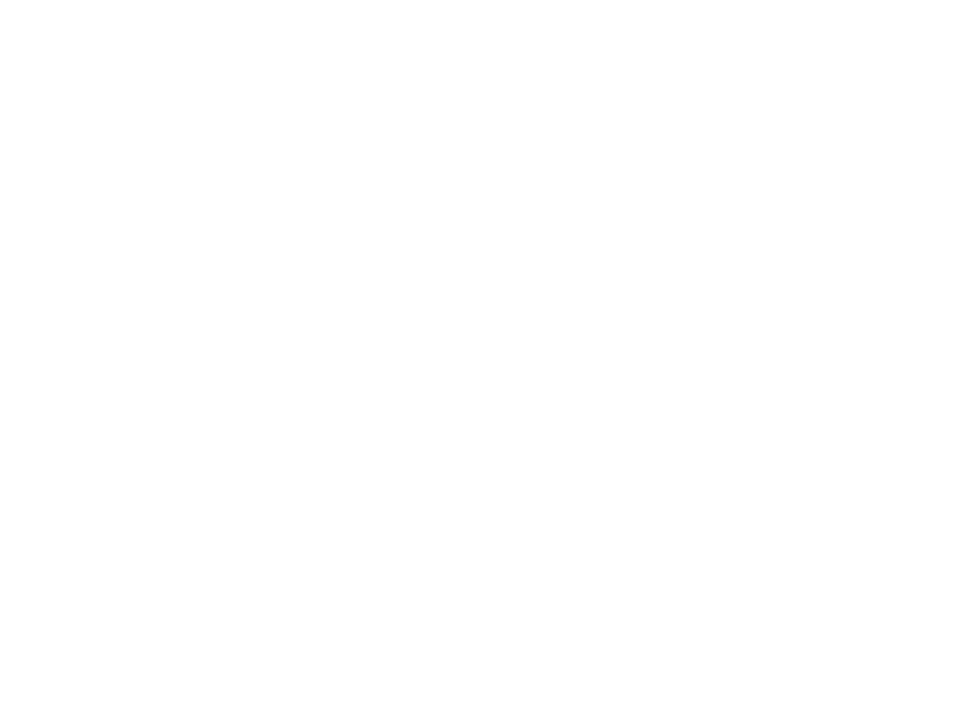

<IPython.core.display.Javascript object>


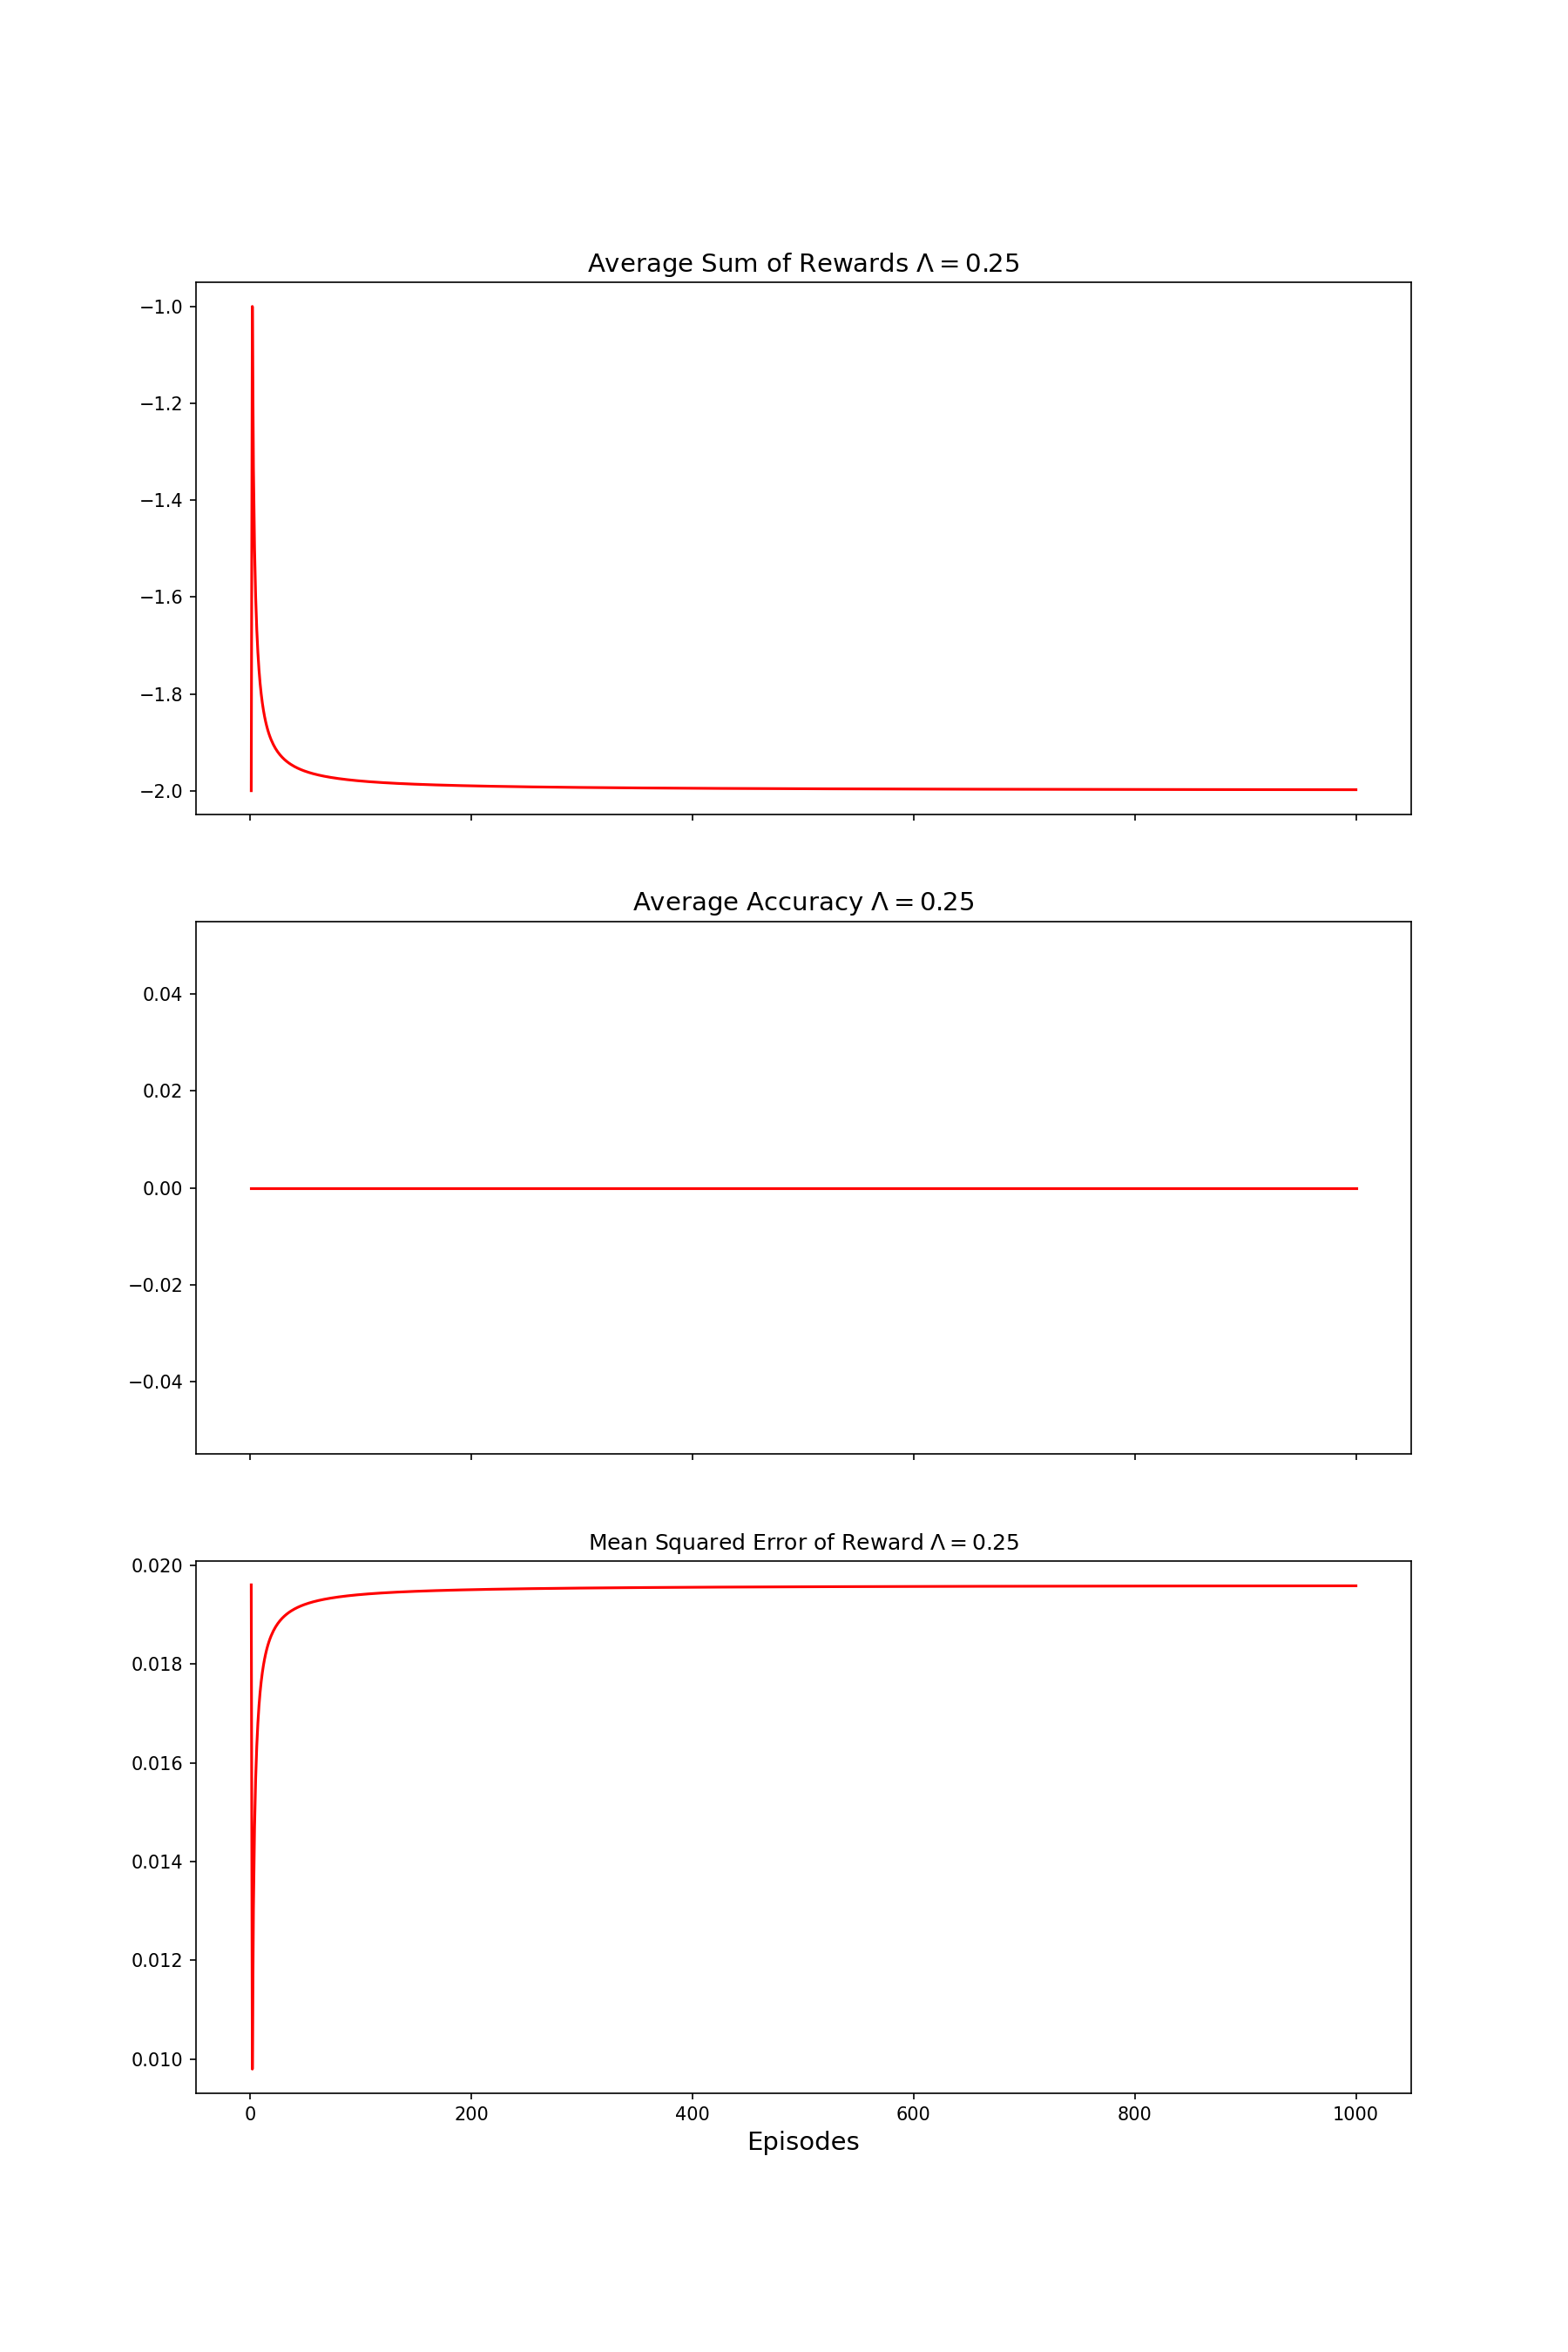

<IPython.core.display.Javascript object>


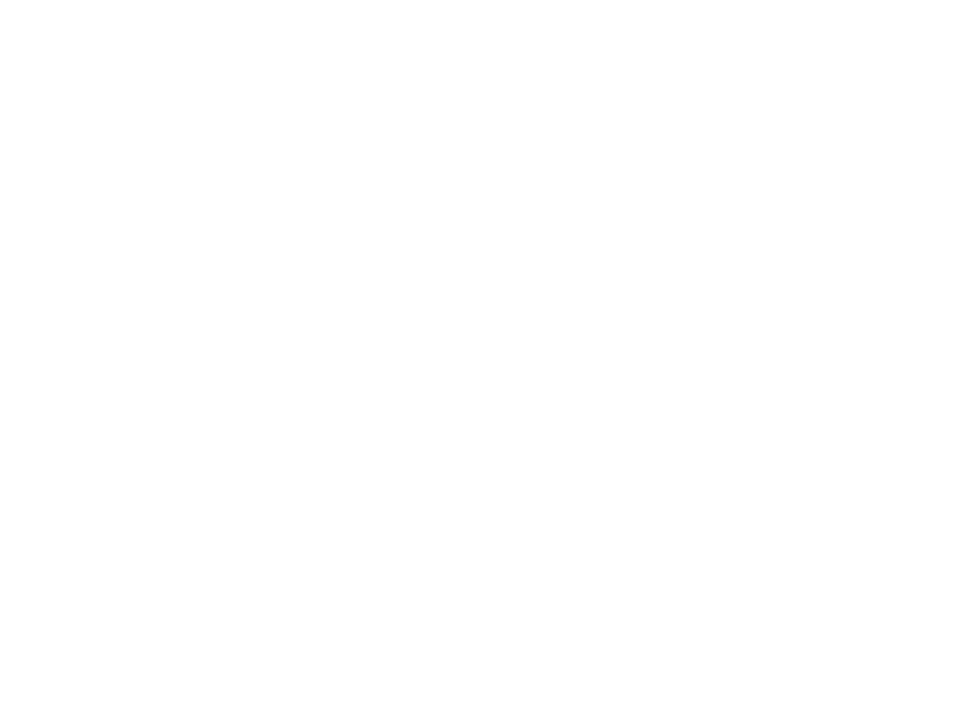

<IPython.core.display.Javascript object>


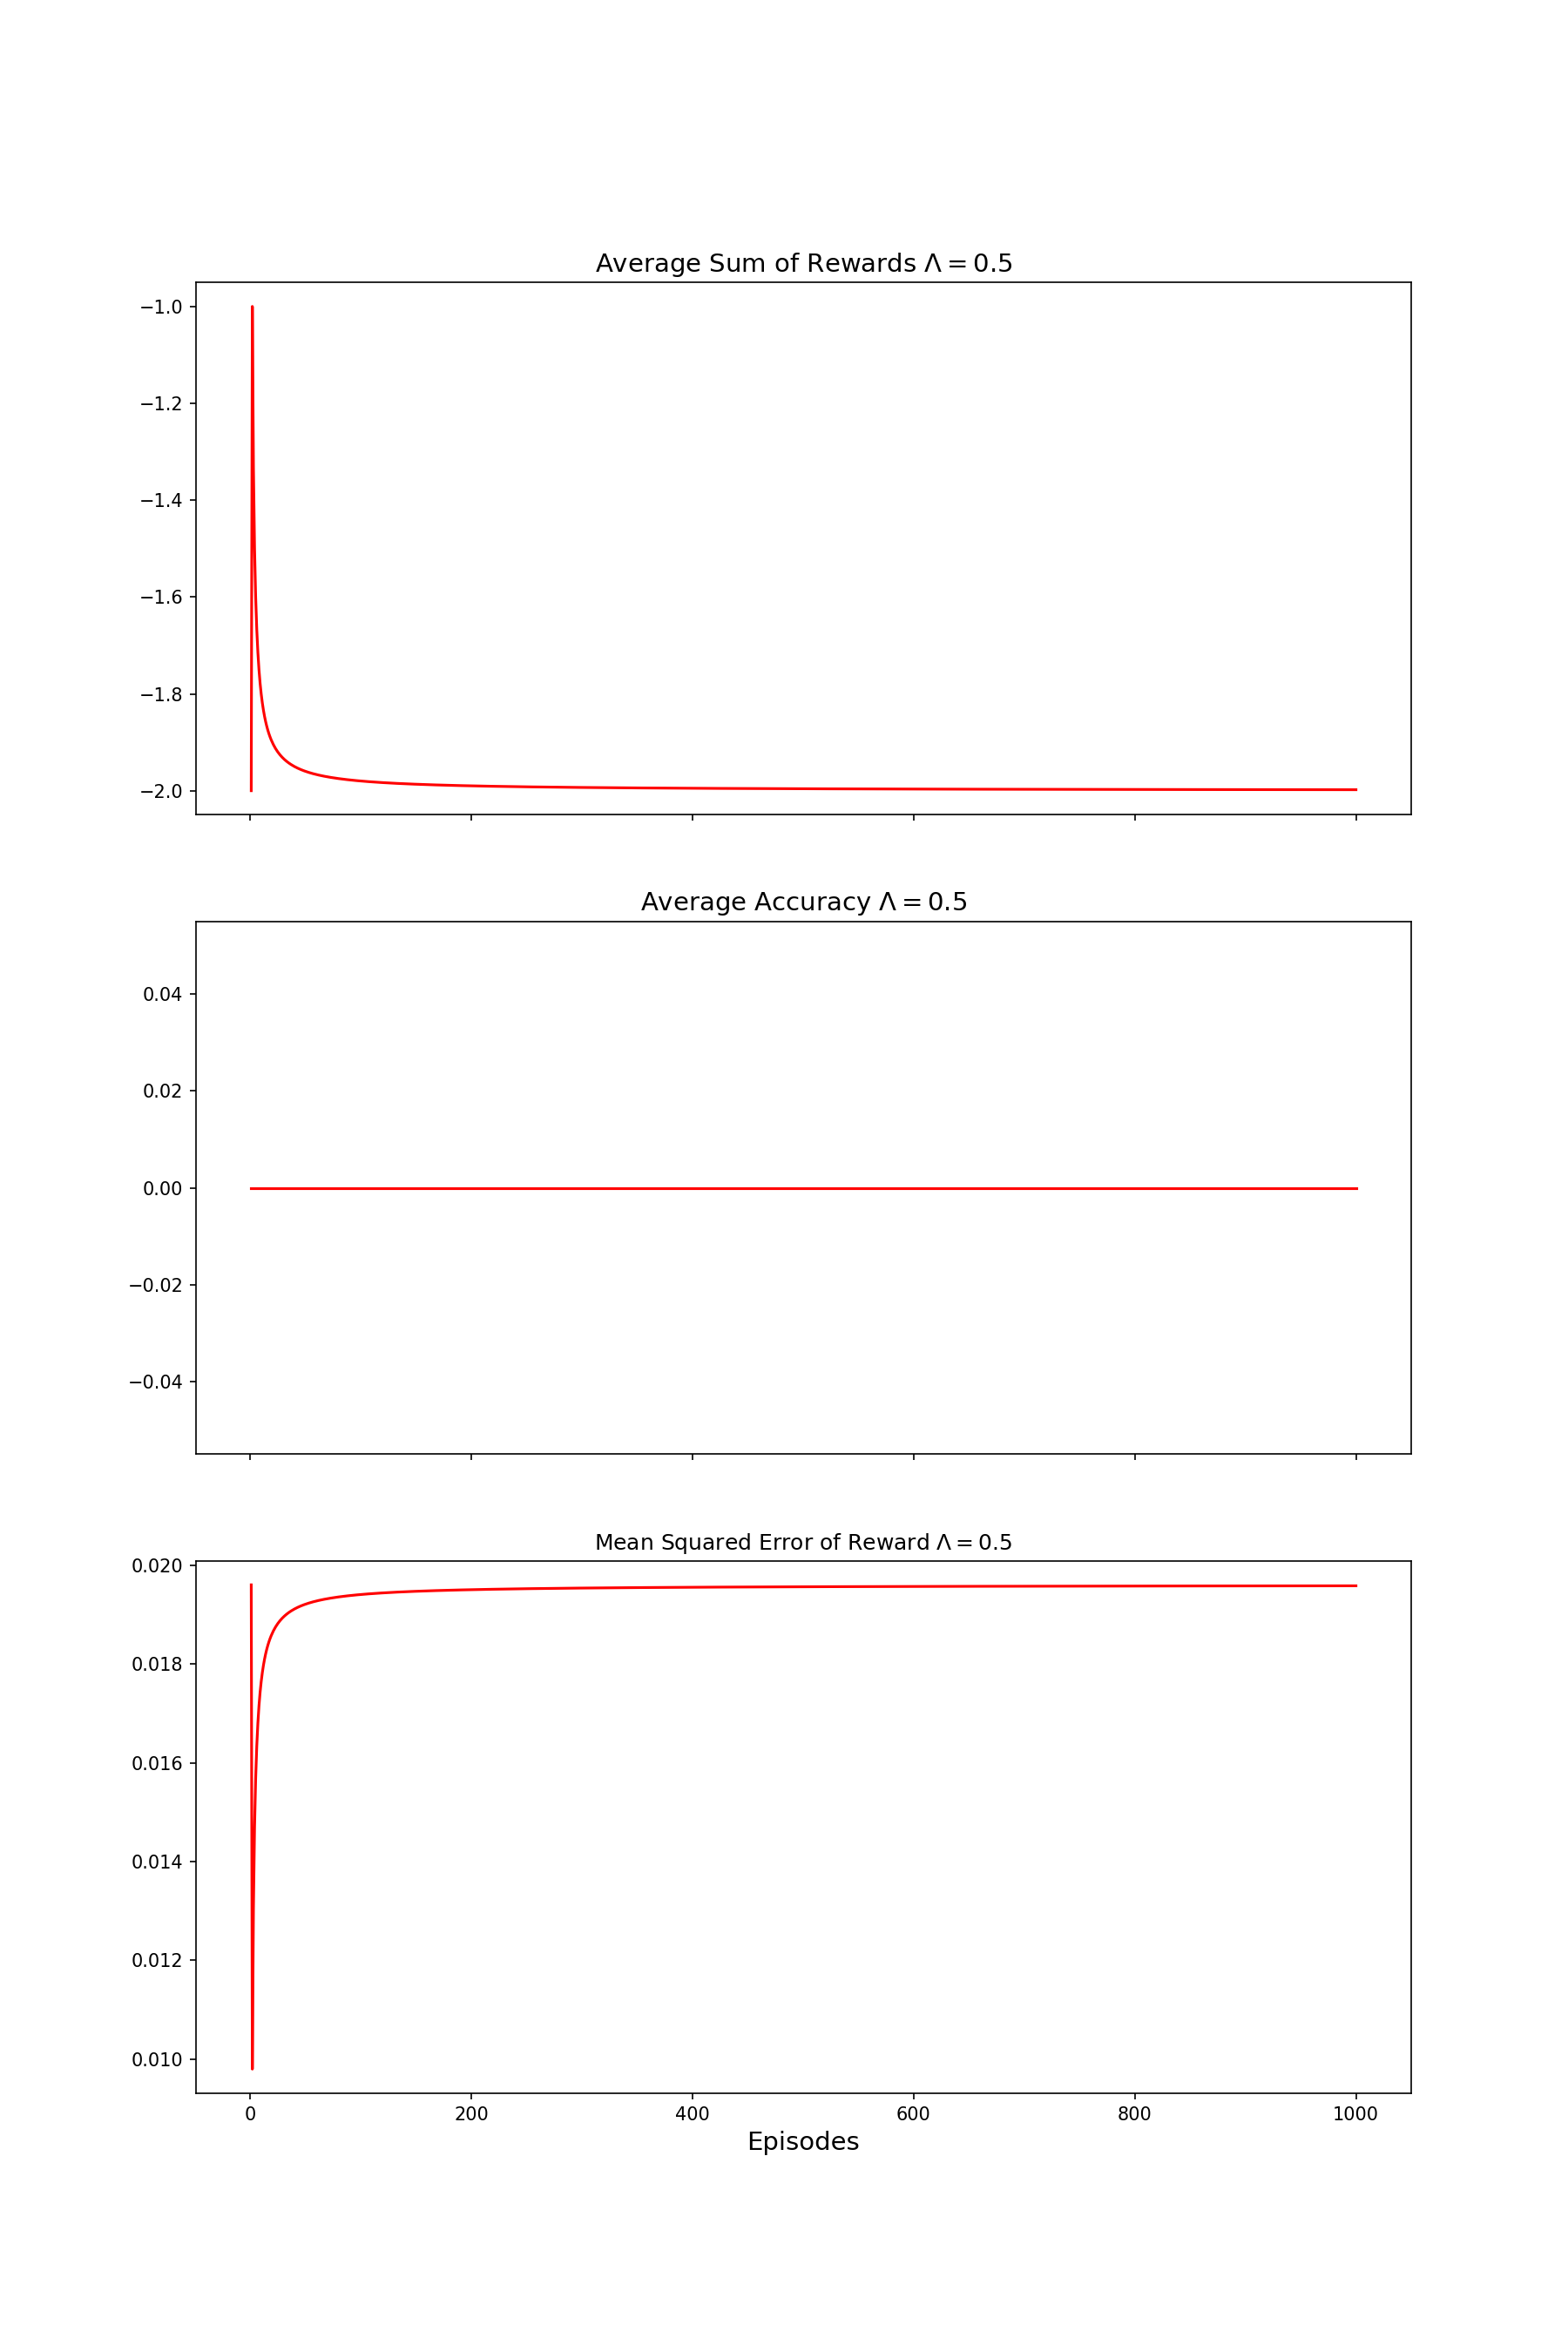

<IPython.core.display.Javascript object>


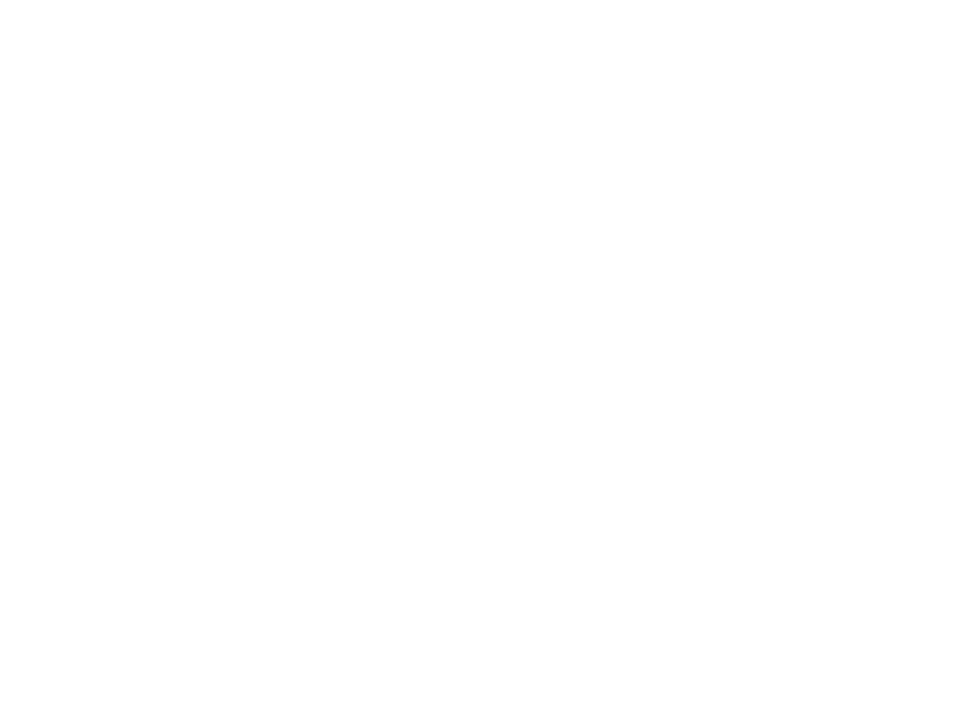

<IPython.core.display.Javascript object>


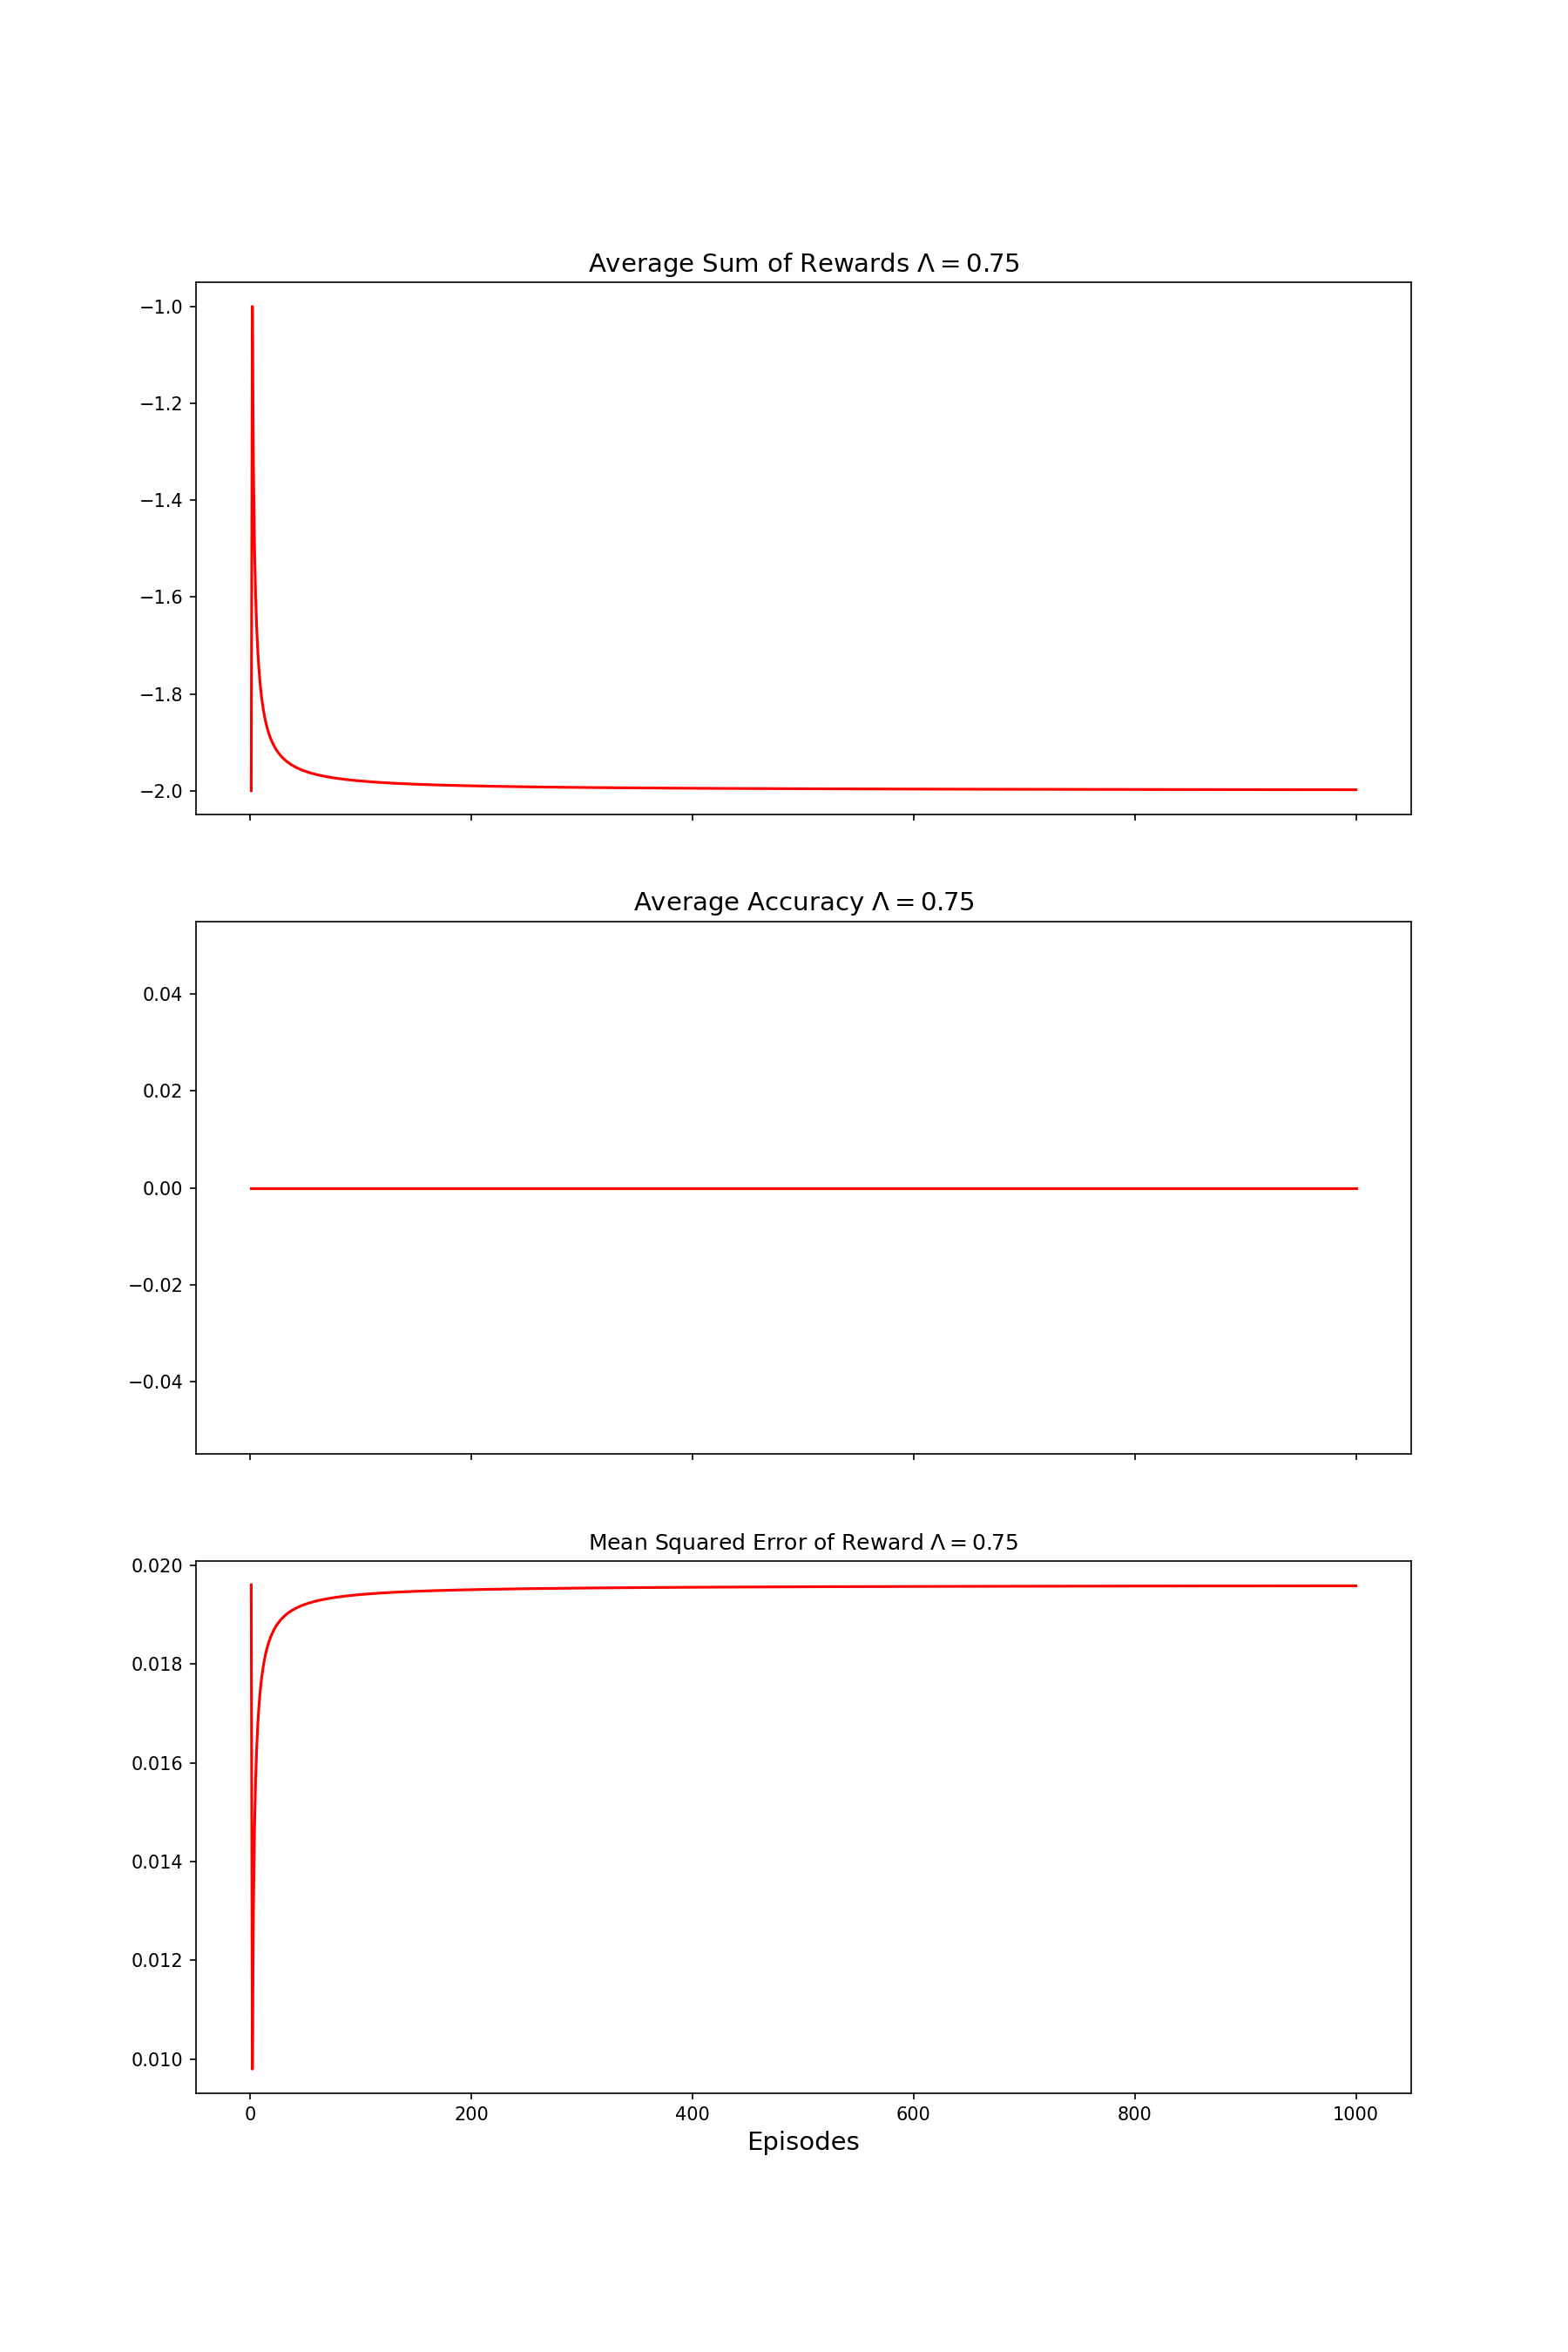

<IPython.core.display.Javascript object>


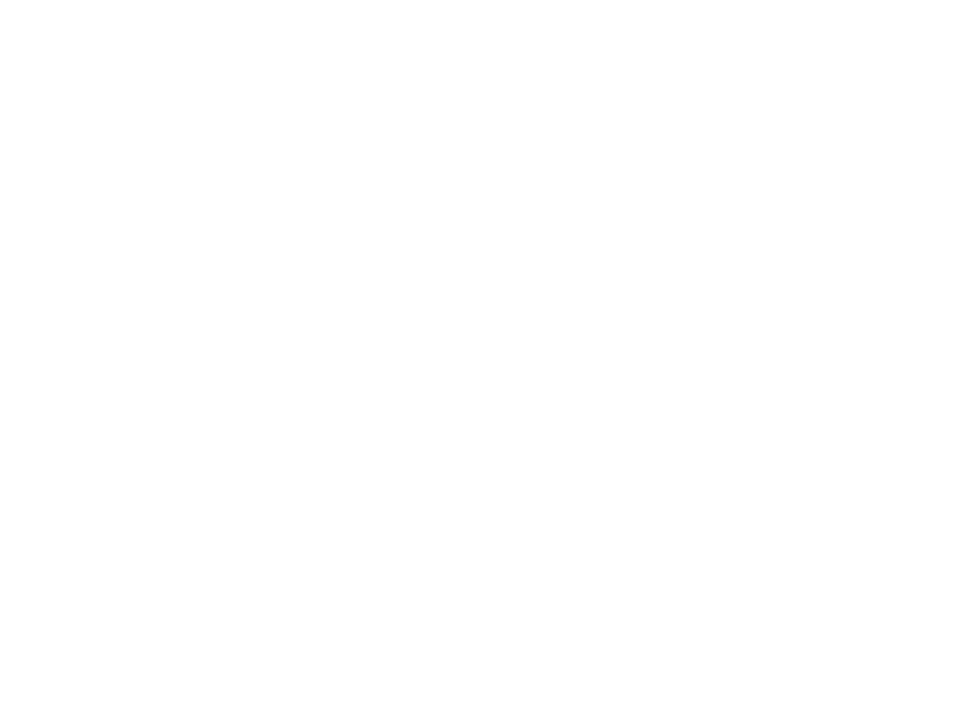

<IPython.core.display.Javascript object>


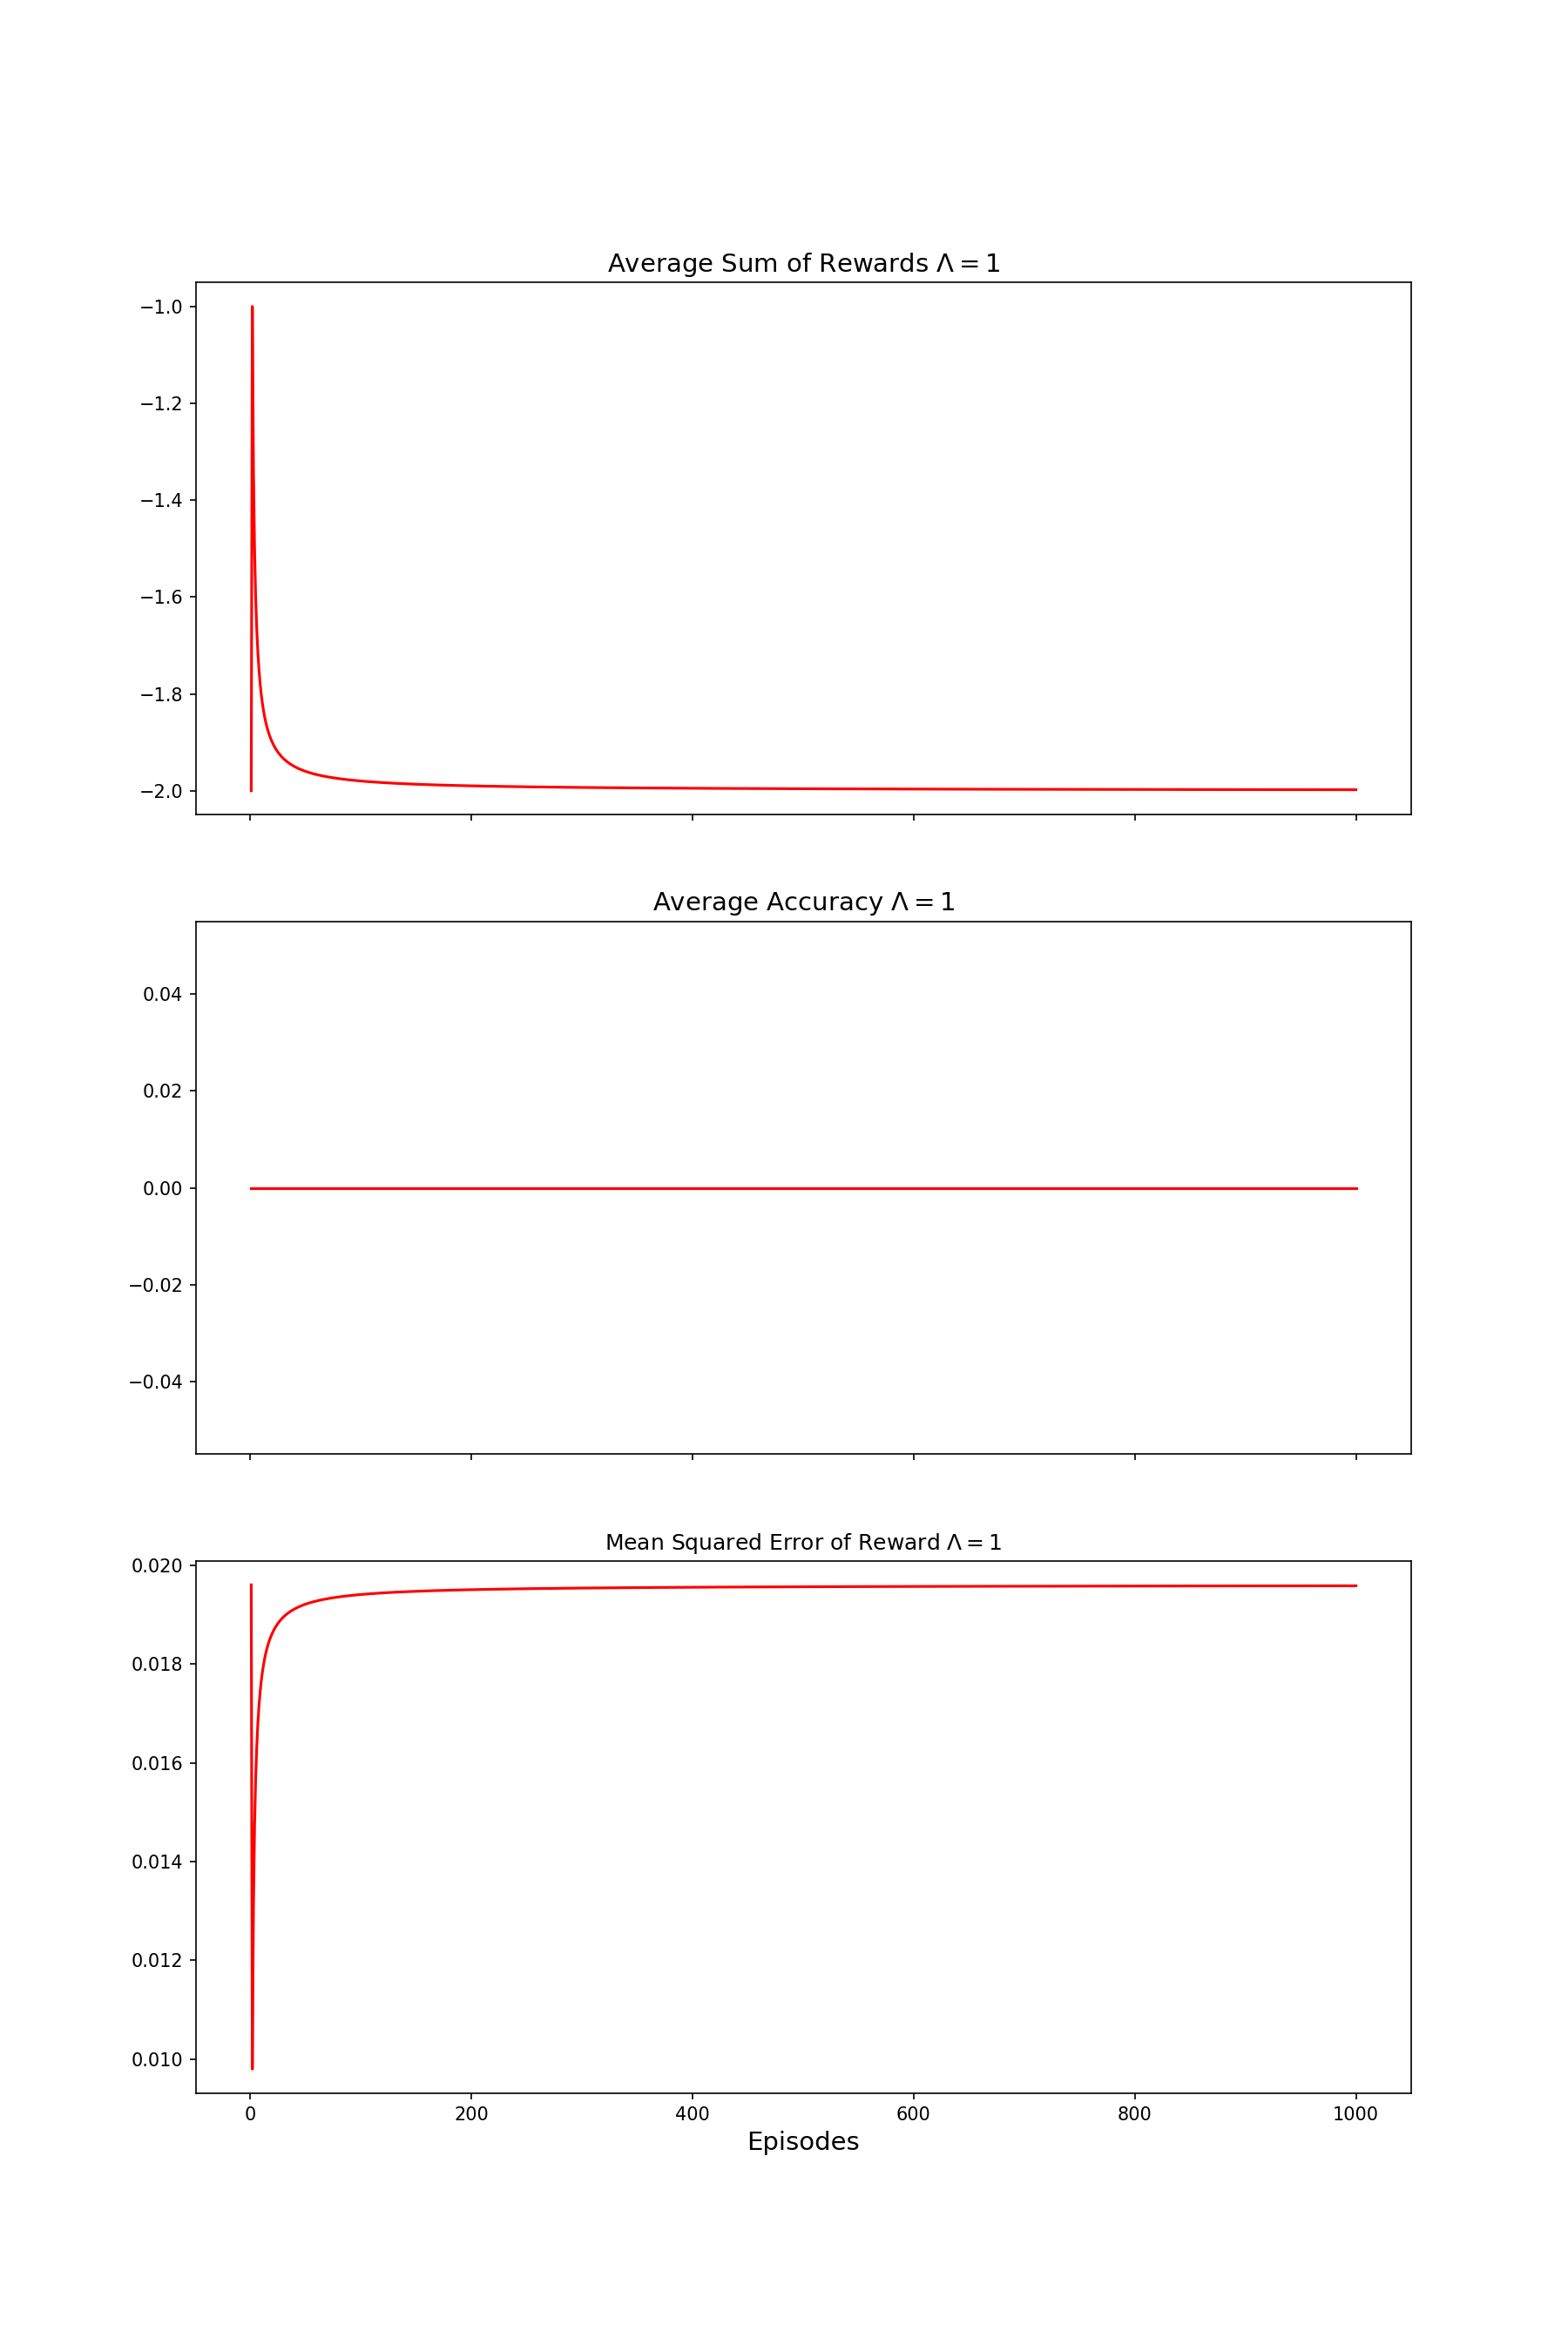

In [34]:
for Lambda in trials:
    Lambda_str = '{}'.format(Lambda).replace('.','_')
    Q = trials[Lambda]['Q']
    hits = trials[Lambda]['hits']
    R_SUM = trials[Lambda]['R_SUM']
    MSE = trials[Lambda]['MSE']
    
    # Example graphs to make:
    # Sum of rewards vs. Episodes
    # % accuracy vs. Episodes
    # RMSE vs. Episodes
    plt.figure()
    episodes = np.arange(1, NUM_EPISODES+1, 1)

    R_Sum_Ave = np.zeros((NUM_EPISODES))
    accuracy = np.zeros((NUM_EPISODES))
    MSE_Ave = np.zeros((NUM_EPISODES))

    R_Sum_Ave[0] = R_SUM[0]
    R_Sum_Ave[1:] = np.asarray([np.sum(R_SUM[:n])/(n+1) for n in range(1, NUM_EPISODES)])

    accuracy[0] = hits[0]
    accuracy[1:] = np.asarray([np.sum(hits[:n])/(n+1) for n in range(1, NUM_EPISODES)])

    MSE_Ave[0] = MSE[0]
    MSE_Ave[1:] = np.asarray([np.sum(MSE[:n])/(n+1) for n in range(1, NUM_EPISODES)])

    # Make an example graph
    fig, axes = plt.subplots(figsize = [12,18], nrows = 3, ncols = 1, sharex = True)
    ax1 = axes[0]; ax2 = axes[1]; ax3 = axes[2]

    ax1.plot(episodes, R_Sum_Ave, 'r-')
    ax1.set_title('Average Sum of Rewards $\\Lambda={}$'.format(Lambda), fontsize = 14)

    ax2.plot(episodes, accuracy, 'r-')
    ax2.set_title('Average Accuracy $\\Lambda={}$'.format(Lambda), fontsize = 14)

    ax3.plot(episodes, MSE_Ave, 'r-')
    ax3.set_title('Mean Squared Error of Reward $\\Lambda={}$'.format(Lambda))
    ax3.set_xlabel('Episodes', fontsize = 14)

    plt.show(block = False)
    plt.savefig('Sarsa-Lambda-Learning_Lambda_{}.png'.format(Lambda_str))
    
    # Write the data to a comma seperated text file for comparison with another algorithm.
    # Naming format:
    # Q-Learning_mo_nr.txt
    # mo refers to the number of obstacles used when the model learned
    #   (e.g., 0o is 0 obstacles, 1o is 1 obstacle, etc.)
    # nr will be filled with:
    #   nr: No Randomized (neither target nor agent were randomized per episode)
    #   tr: Target Randomized (only the target was randomized per episode)
    #   ar: Agent Randomized (only the agent was randomized per episode)
    #   br: Both Randomized (both the target and agent were randomized per episode)

    # Variables saved are:
    #   Episodes
    #   Hit/Miss for that episode
    #   Sum of Rewards for that episode (SR)
    #   Mean Square Error (Variance) for that episode (MSE)

    # Write the file
    f = open('Sarsa-Lambda-Learning_Lambda_{}.txt'.format(Lambda_str), 'w')

    # Write the headers
    f.write('Episode,Hit,SR,MSE' + '\n')

    # Write the data
    for n in range(NUM_EPISODES):
        f.write(str(episodes[n]) + ',' + str(hits[n]) + ',' + str(R_SUM) + ',' + str(MSE) + '\n')

    # Close the file when finished
    f.close()

In [35]:
alpha_str

'0_05'